# Week 3 CNN Cancer Detection Mini Project
### Malcolm Bailey

## Introduction
Earlier identification of cancer cells is an important tool for fighting cancer. For this assignment, we worked on a dataset of histopathologic scans of lymph node sections. Our goal was to use this data with machine learning to classify images as containing potentially dangerous metastatic tissue. The data we were given was a large dataset of 96 x 96 pixel tif images with 3 channels (RGB). Our training set contained a total of 220025 images, leaving us with a final dimension of (220025, 96, 96, 3) for the training data.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, datasets
from tensorflow.keras.activations import sigmoid
import numpy as np
import pandas as pd
from PIL import Image
import os
import re
import matplotlib.pyplot as plt

2025-02-19 12:58:08.829455: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739995088.918096  197088 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739995088.943495  197088 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 12:58:09.146876: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load Data
# The data is stored inside of a "train" file as a large series of images.
# Each File name is an id that corresponds to a label stored inside train_labels.csv
train_data_dir = "./data/train/" 
raw_train_labels = pd.read_csv("./data/train_labels.csv", index_col='id')

In [3]:
raw_train_labels.head()

,label
id,
f38a6374c348f90b587e046aac6079959adf3835,0
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
755db6279dae599ebb4d39a9123cce439965282d,0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
068aba587a4950175d04c680d38943fd488d6a9d,0


(96, 96)
./data/train/c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif


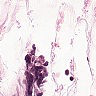

In [4]:
example_file = f"{train_data_dir}c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif"
example_image = Image.open(example_file)
print(example_image.size)
print(example_image.filename)
example_image.show()

## Exploratory Data Analysis (EDA)
Based on some of my code below, we see example images. Our problem statement mentions that we are only interested in the center 32 x 32 pixels for each image to identify our label, _"A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image."_

For this reason, I opted to cut down image size to the center 32 x 32 images as it seems like the info we need is contained there. We can see this farther down in the giant code black inside the #generate_train_data method. We also know that the image values go between 0 and 255, so we will add a normalization layer before the network.

In [5]:
img_labels = pd.read_csv("./data/train_labels.csv", index_col='id')
print("There are a total of " + str(len(img_labels)) + " training samples")
img_labels.head()

There are a total of 220025 training samples


,label
id,
f38a6374c348f90b587e046aac6079959adf3835,0
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
755db6279dae599ebb4d39a9123cce439965282d,0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
068aba587a4950175d04c680d38943fd488d6a9d,0


In [53]:
class GenerateData:
    target_height = 64
    target_width = 64
    channels = 3
    def generate_train_data(source_dir, img_label_path):
        directory = os.fsencode(source_dir)
        img_labels = pd.read_csv(img_label_path, index_col='id')
        # make the label int8 to save space
        img_labels['label'] = np.uint8(img_labels['label'])
        # each image is 96 x 96 pixels, and it has 3 channels (RGB)
        # The assignment clarifies we only want the center 32 x 32 pixels, so we can ignore any pixels outside of that
        target_height = GenerateData.target_height
        target_width = GenerateData.target_width
        channels = GenerateData.channels
        left_boundary = (96 - target_width) // 2
        right_boundary = 96 - left_boundary
        top_boundary = (96 - target_height) // 2
        bottom_boundary = 96 - top_boundary
        image_filepaths = []
        id_to_filepath = {}
        for filename in os.listdir(source_dir):
            # Store paths
            image_filepaths.append(os.path.join(source_dir, filename))  
            
        num_images = len(image_filepaths)
        img_array = np.zeros((num_images, target_height, target_width, channels), dtype=np.uint8)
        labels = np.zeros(num_images, dtype=np.int8)
        for n, filepath in enumerate(image_filepaths):
            with Image.open(filepath) as img:
                img_array[n, :, :, :] = np.array(img)[left_boundary:right_boundary, top_boundary:bottom_boundary, :]
            filename = re.search(r'[\w\d]+(?=\.tif)', filepath)[0]
            labels[n] = img_labels.loc[filename]['label']
            id_to_filepath[n] = filepath
        return img_array, labels, id_to_filepath

    def generate_test_data(source_dir):
        directory = os.fsencode(source_dir)
        # each image is 96 x 96 pixels, and it has 3 channels (RGB)
        # The assignment clarifies we only want the center 32 x 32 pixels, so we can ignore any pixels outside of that.
        target_height = GenerateData.target_height
        target_width = GenerateData.target_width
        channels = GenerateData.channels
        left_boundary = (96 - target_width) // 2
        right_boundary = 96 - left_boundary
        top_boundary = (96 - target_height) // 2
        bottom_boundary = 96 - top_boundary
        image_filepaths = []
        id_to_filepath = {}
        for filename in os.listdir(source_dir):
            image_filepaths.append(os.path.join(source_dir, filename))  # Store paths
            
        num_images = len(image_filepaths)
        img_array = np.zeros((num_images, target_height, target_width, channels), dtype=np.uint8)
        
        for n, filepath in enumerate(image_filepaths):
            with Image.open(filepath) as img:
                img_array[n, :, :, :] = np.array(img)[left_boundary:right_boundary, top_boundary:bottom_boundary, :]
            id_to_filepath[n] = filepath
        return img_array, id_to_filepath

    def save_data(train_img_data, train_labels):
        np.savez('train_img_data.npz', train_img_data)
        np.save('train_img_labels.npy', train_labels)
        return "Saved training data to train_img_data.npz and labels to train_img_data.npy"

    def load_data():
        # Load data from checkpoint
        load_train_img_data = np.load('train_img_data.npz')
        train_img_data = load_train_img_data['arr_0']
        train_labels = np.load('train_img_labels.npy')
        return (train_img_data, train_labels)


In [19]:
# load data into numpy arrays, save for faster access later
train_img_data, train_labels, id_to_filename = GenerateData.generate_train_data("./data/train/", "./data/train_labels.csv")
# GenerateData.save_data(train_img_data, train_labels)

16 80


In [20]:
# fetch saved arrays
if 'train_img_data' not in locals():
    train_img_data, train_labels = GenerateData.load_data()
    # construct a mapping from index to filename for looking at  specific images
id_to_filename = {n: name for n, name in enumerate(os.listdir("./data/train/"))} 

Image shape is (64, 64, 3)


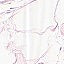

In [21]:
image_index = 5
image = train_img_data[image_index]
print("Image shape is {}".format(image.shape))
Image.fromarray(image)

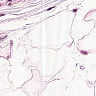

In [22]:
image_path = f"./data/train/{id_to_filename[image_index]}"
full_image = Image.open(f"{image_path}")
full_image.show()

### EDA - Calculating the mean image values

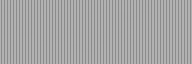

In [23]:
mean_rgb = np.array(np.mean(train_img_data, axis=0), dtype = np.uint32)
mean_img = np.concatenate([slice for slice in mean_rgb], axis = 1) 
Image.fromarray(mean_img).show()

### Notes on Image Loading
When I first tried to load images via keras' processing images method: 
```ValueError: No training images found in directory ./data/train/. Allowed formats: ('.bmp', '.gif', '.jpeg', '.jpg', '.png')``` \
This mean I couldn't use Keras' built in image processing features, and I instead opted for the Image library from PIL for handling the image data.

### Data Prep For ML

Below we batch, shuffle, and split our data into a training and validate set. This helps immensely for performance of training the CNN, and keep a validation set allows us to keep track of our overfitting issues.

In [24]:
total_dataset = tf.data.Dataset.from_tensor_slices((train_img_data, train_labels))

I0000 00:00:1739995993.199097  197088 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9057 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:09:00.0, compute capability: 7.5
2025-02-19 13:13:13.207795: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2703667200 exceeds 10% of free system memory.
2025-02-19 13:13:14.896165: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2703667200 exceeds 10% of free system memory.


In [34]:
# shuffle and split into train/validate sets
BATCH_SIZE = 128
TRAIN_SPLIT = 0.8
SHUFFLE_BUFFER_SIZE = 256

# Shuffle the data and Batch the data
total_dataset = total_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# split the data into a train and validate set
train_size = int(TRAIN_SPLIT * len(list(total_dataset)))
final_train_dataset = total_dataset.take(train_size)
validate_dataset = total_dataset.skip(train_size)

# 4. (Optional) Prefetch for performance
final_train_dataset = final_train_dataset.prefetch(tf.data.AUTOTUNE)

2025-02-19 13:14:01.717190: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2703667200 exceeds 10% of free system memory.
2025-02-19 13:14:03.663195: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Building Models

I have changed the below chunk many many times depending on what architecture I wanted to try. My initial attempts involved a combination of 1 - 2 CNN layers (which were 2-3 convolution layers with batch normalization, RELU activation functions, and Max Pooling) with 1-2 dense layers after that.

I spent the better part of two days tinkering with this structure, iterating on slightly more or less parameters. No matter what, I was hovering around the 0.75 ish mark on test error + validation error. Based on the scores in kaggle, I figured I was missing something and so I went back to our class notes and the kaggle discussions and learned about RESNET.

### First Model

In [38]:
# build model 
model1 = keras.models.Sequential()
model1.add(layers.Input(shape=(GenerateData.target_width, GenerateData.target_height, 3)))
model1.add(layers.Rescaling(1./255))

model1.add(layers.Conv2D(8, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(16, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(32, (3, 3)))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.Conv2D(64, (3, 3)))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.MaxPool2D(2,2))

model1.add(layers.Flatten())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dropout(0.25))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.1))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.1))
model1.add(layers.Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 62, 62, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 62, 62, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 62, 62, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 60, 60, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 60, 60, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 60, 60, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 58, 58, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 58, 58, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 58, 58, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,460,145 (24.64 MB)

 Trainable params: 6,459,905 (24.64 MB)

 Non-trainable params: 240 (960.00 B)

In [39]:
# train model

model1.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy,
  metrics=['binary_accuracy', 'auc'])

history1 = model1.fit(final_train_dataset, epochs=10, validation_data=validate_dataset)

Epoch 1/8


2025-02-19 13:14:16.759872: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2703667200 exceeds 10% of free system memory.
I0000 00:00:1739996059.627882  197348 service.cc:148] XLA service 0x7f92bc0208a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739996059.628733  197348 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-02-19 13:14:19.734051: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739996060.177826  197348 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-19 13:14:21.286070: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[128,8,62,62]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,3,64,64]{3,2,1,0}, f32[8,3,3,3]{3,2,1,0}, f32[8]{0}), w

   2/1375 ━━━━━━━━━━━━━━━━━━━━ 1:10 52ms/step - auc: 0.4944 - binary_accuracy: 0.5156 - loss: 1.6720  

I0000 00:00:1739996066.246758  197348 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1373/1375 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - auc: 0.8122 - binary_accuracy: 0.7609 - loss: 0.8227 

2025-02-19 13:14:51.977718: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2703667200 exceeds 10% of free system memory.
2025-02-19 13:14:53.695386: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[128,8,62,62]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,3,64,64]{3,2,1,0}, f32[8,3,3,3]{3,2,1,0}, f32[8]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-19 13:14:53.806381: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[128,16,60,60]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,8,62,62]{3,2,1,0}, f32

1375/1375 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - auc: 0.8123 - binary_accuracy: 0.7610 - loss: 0.8220 - val_auc: 0.8774 - val_binary_accuracy: 0.8045 - val_loss: 0.4580
Epoch 2/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - auc: 0.9113 - binary_accuracy: 0.8404 - loss: 0.3707 - val_auc: 0.8696 - val_binary_accuracy: 0.7968 - val_loss: 0.4664
Epoch 3/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - auc: 0.9236 - binary_accuracy: 0.8514 - loss: 0.3446 - val_auc: 0.9090 - val_binary_accuracy: 0.8422 - val_loss: 0.3989
Epoch 4/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - auc: 0.9301 - binary_accuracy: 0.8577 - loss: 0.3300 - val_auc: 0.9115 - val_binary_accuracy: 0.8340 - val_loss: 0.3943
Epoch 5/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - auc: 0.9348 - binary_accuracy: 0.8642 - loss: 0.3197 - val_auc: 0.9215 - val_binary_accuracy: 0.8530 - val_loss: 0.3867
Epoch 6/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - auc: 0.9384 - binary_accuracy: 0.8681 - loss: 0.3111 - val_auc: 0.93

In [40]:
# Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.
# Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

### Second Model

In [41]:
def resnet_layer(layer, num_filters, kernel_size = (3,3)): 

    # create skip_layer
    skip_layer = layers.Conv2D(4 * num_filters, 1)(layer)
    skip_layer = layers.BatchNormalization(axis=3)(skip_layer)

    # create regular resent conv layer with bottleneck
    layer = layers.Conv2D(num_filters, 1, padding='same')(layer)
    # axis 3 because we want to normalize each color channel
    layer = layers.BatchNormalization(axis=3)(layer)
    layer = layers.Activation('relu')(layer)
    
    layer = layers.Conv2D(num_filters, kernel_size, padding='same')(layer)
    layer = layers.BatchNormalization(axis=3)(layer)
    layer = layers.Activation('relu')(layer)

    # need to multiply by 4 here to match the output from skip layer
    layer = layers.Conv2D(4 * num_filters, 1, padding='same')(layer)
    layer = layers.BatchNormalization(axis=3)(layer)
    
    # add the skip layer
    layer = layers.add([skip_layer, layer])  
    layer = layers.Activation('relu')(layer)
    return layer


In [69]:
# build model 
input_layer = layers.Input(shape=(GenerateData.target_width, GenerateData.target_height, 3))
layer = layers.Rescaling(1./255)(input_layer)
layer = resnet_layer(layer, 8)
layer = layers.MaxPooling2D(2,2)(layer)
layer = resnet_layer(layer, 16, (5,5))
layer = resnet_layer(layer, 32)
layer = resnet_layer(layer, 64)
layer = layers.AveragePooling2D(2,2)(layer)
layer = layers.Flatten()(layer)
layer = layers.Dense(64, activation='relu')(layer)
layer = layers.Dense(64, activation='relu')(layer)
layer = layers.Dense(1, activation='sigmoid')(layer)

model2 = keras.Model(inputs=input_layer, outputs=layer)
model2.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 64, 64, 3) │          0 │ input_layer_8[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 64, 64, 8) │         32 │ rescaling_8[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64, 8) │         32 │ conv2d_77[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_58       │ (None, 64, 64, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 64, 64, 8) │        584 │ activation_58[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64, 8) │         32 │ conv2d_78[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_59       │ (None, 64, 64, 8) │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 64, 64,    │        128 │ rescaling_8[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 64, 64,    │        288 │ activation_59[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_76[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_79[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_60       │ (None, 64, 64,    │          0 │ add_18[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ activation_60[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 32, 32,    │        528 │ max_pooling2d_6[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_81[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 4,333,289 (16.53 MB)

 Trainable params: 4,330,889 (16.52 MB)

 Non-trainable params: 2,400 (9.38 KB)

In [70]:
# train model

model2.compile(
  optimizer='adam',
  loss=tf.keras.losses.BinaryCrossentropy,
  metrics=['binary_accuracy', 'auc'])

history2 = model2.fit(final_train_dataset, epochs=8, validation_data=validate_dataset)

Epoch 1/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 68s 40ms/step - auc: 0.8783 - binary_accuracy: 0.8179 - loss: 0.6565 - val_auc: 0.8637 - val_binary_accuracy: 0.7693 - val_loss: 0.5252
Epoch 2/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 52s 38ms/step - auc: 0.9419 - binary_accuracy: 0.8748 - loss: 0.2992 - val_auc: 0.9302 - val_binary_accuracy: 0.8436 - val_loss: 0.3770
Epoch 3/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 54s 39ms/step - auc: 0.9516 - binary_accuracy: 0.8867 - loss: 0.2732 - val_auc: 0.9202 - val_binary_accuracy: 0.8402 - val_loss: 0.4020
Epoch 4/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 52s 38ms/step - auc: 0.9569 - binary_accuracy: 0.8940 - loss: 0.2579 - val_auc: 0.8943 - val_binary_accuracy: 0.8089 - val_loss: 0.4752
Epoch 5/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 54s 39ms/step - auc: 0.9616 - binary_accuracy: 0.9007 - loss: 0.2436 - val_auc: 0.9393 - val_binary_accuracy: 0.8672 - val_loss: 0.3146
Epoch 6/8
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 52s 38ms/step - auc: 0.9661 - binary_accuracy: 0.9077 - loss: 0.2286 - val

## Results and Analysis (35 pts)

### The dark ages (my first attempts before Resnet)
For my first go around, I created a LOT of simple architectures like the first one listed below. These would have minor variances in performance but would all essentially perform the same (poorly). Attached below is one example of what was probably 40+ model attempts. 

```
auc: 0.9439 - binary_accuracy: 0.8756 - loss: 0.2964 - val_auc: 0.9405 - val_binary_accuracy: 0.8705 - val_loss: 0.3231
```

#### Example architecture for most of my attempts with basic CNN layers:
```
model.add(layers.Input(shape=(32, 32, 3)))
model.add(layers.Rescaling(1./255))

model1.add(layers.Conv2D(8, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(16, (3, 3)))
model1.add(layers.Activation('relu'))
model1.add(layers.BatchNormalization())
model1.add(layers.Conv2D(32, (3, 3)))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.Conv2D(64, (3, 3)))
model1.add(layers.BatchNormalization())
model1.add(layers.Activation('relu'))
model1.add(layers.MaxPool2D(2,2))

model1.add(layers.Flatten())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dropout(0.25))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.1))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.1))
model1.add(layers.Dense(1, activation='sigmoid'))
```

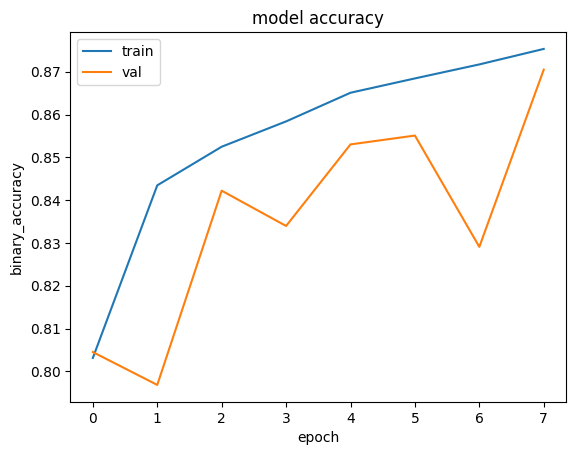

In [48]:
plt.plot(history1.history['binary_accuracy'])
plt.plot(history1.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

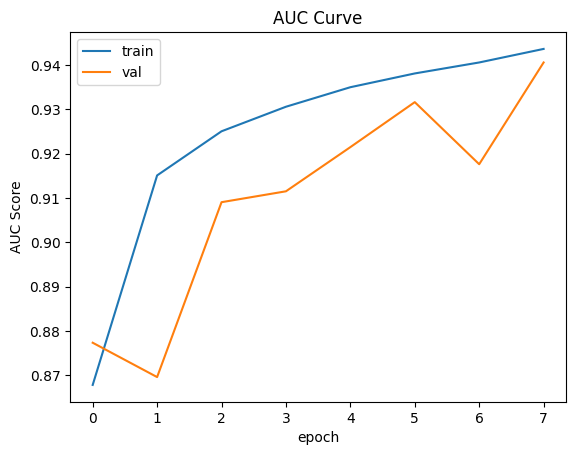

In [49]:
plt.plot(history1.history['auc'])
plt.plot(history1.history['val_auc'])
plt.title('AUC Curve')
plt.ylabel('AUC Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model 2 - Resnet With Bottleneck Attempt

## Second Model
```
input_layer = layers.Input(shape=(96, 96, 3))
layer = layers.Rescaling(1./255)(input_layer)
layer = resnet_layer(layer, 16)
layer = resnet_layer(layer, 32)
layer = layers.MaxPooling2D(2,2)(layer)
layer = resnet_layer(layer, 64)
layer = resnet_layer(layer, 128)
layer = layers.AveragePooling2D(2,2)(layer)
layer = layers.Flatten()(layer)
layer = layers.Dense(64, activation='relu')(layer)
layer = layers.Dense(1, activation='sigmoid')(layer)

model = keras.Model(inputs=input_layer, outputs=layer)
```

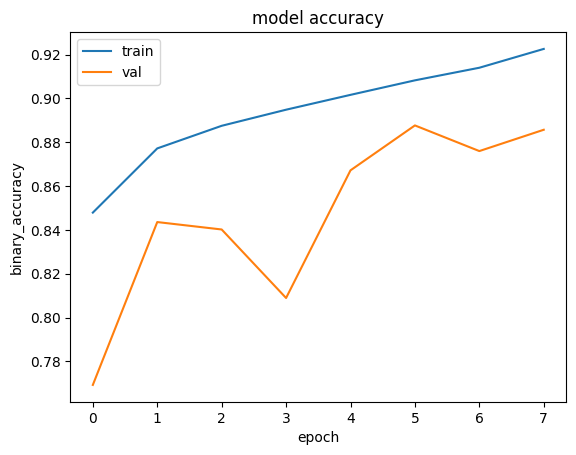

In [71]:
plt.plot(history2.history['binary_accuracy'])
plt.plot(history2.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

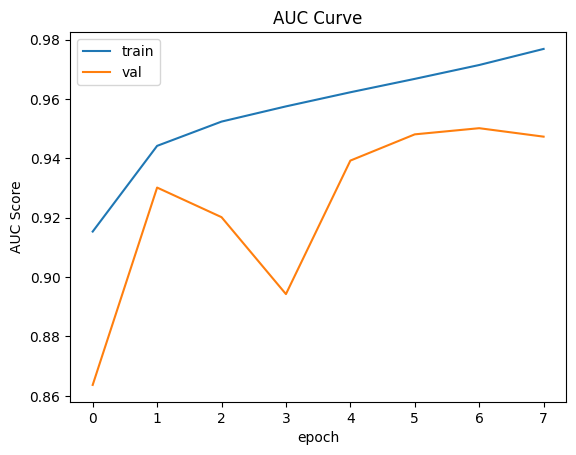

In [72]:
plt.plot(history2.history['auc'])
plt.plot(history2.history['val_auc'])
plt.title('AUC Curve')
plt.ylabel('AUC Score')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Generate Test Predictions For Kaggle

In [73]:
# get test data
if 'test_img_array' not in locals():
    test_img_array, id_to_filepath = GenerateData.generate_test_data("./data/test/")

In [74]:
# I want to get id to filenames instead of file path for storing the results
id_to_filename = {k: re.search(r'[\w\d]+(?=\.tif)', v)[0] for k, v in id_to_filepath.items()}

In [75]:
# to avoid memory issues, iterate through small batches, make tensors, and then predict
model = model2 # pick which model I want to use as a predict

batch_size = 16 
num_images = test_img_array.shape[0]
num_batches = int(np.ceil(num_images / batch_size))  # Calculate the number of batches
predictions = np.zeros((num_images, 1))
for i in range(num_batches):
    start = i * batch_size
    end = min(num_images, (i + 1) * batch_size)
    batch_images = test_img_array[start:end]
    # Convert to tensor
    test_img_tensor = tf.convert_to_tensor(batch_images)
    
    batch_predictions = model.predict(test_img_tensor, verbose=0)
    predictions[start:end] = batch_predictions
    

2025-02-19 14:15:28.661365: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,8,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,8,64,64]{3,2,1,0}, f32[8,8,3,3]{3,2,1,0}, f32[8]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-19 14:15:28.900890: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,16,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,16,32,32]{3,2,1,0}, f32[16,16,5,5]{3,2,1,0}, f32[16]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForw

In [76]:
predicted_labels = (predictions >= 0.5).astype(int)
predictions_df = pd.DataFrame(predicted_labels)
predictions_df.index = predictions_df.index.map(id_to_filename)
predictions_df.index.name = 'id'
predictions_df = predictions_df.rename({0: 'label'}, axis=1)
predictions_df.to_csv("test_predictions.csv")

## Analysis

#### Troubleshooting
Thanks to the graphs that showed validation error, I was able to identify quickly when we were overfitting. I also encountered some issues with network degradation, as some of my more complex models would never improve over the course of 20+ epochs. I didn't remember the resnet until I did some googling, so finding that and implementing that helped a bit (though less than I anticipiated).


#### Worked Well
- keeping moderate complexity for basic CNN layers (think 50k-400k parameters at most)
- more complexity once we introduced resnet
- using 3x3 kernels
- single dense layer at the end


#### Didn't work so well
- large complexity on basic CNN (fails due to vanishing gradient)
- trying larger kernels with many cnns (too big, training time explodes)
- using multiple dense layers at the end
- 128 filter CNN's seemed to be overkill and nuke the training




## Conclusion

#### Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

So my results seemed to be alright at best compared to the leaderboard. On average, I was landing around 0.75 to 0.8 for test accuracy. Switching from a general CNN to one with the skip (like resnet) helped with vanishing gradient issues. I think this could be partly because I was cutting the images down to the center 32x32 when maybe some external factors existed that would've allowed us to more accurately label images. In the future, I could try:
- rotating images to provide more data
- get higher resolution images
- add more images to the dataset

Batch size affects training by influencing the speed and accuracy of the model's learning process. Larger batch sizes can lead to faster training times but may result in lower accuracy and overfitting, while smaller batch sizes can improve accuracy but may slow down the training process.

I would also love to try larger models of resnet, and potentially incorporate some features from GoogLeNet.